In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [3]:
train_df = pd.read_csv("DIA_trainingset_RDKit_descriptors.csv")
test_df = pd.read_csv("DIA_testset_RDKit_descriptors.csv")

# Drop non-numeric columns like SMILES (optional, unless needed)
X = train_df.drop(columns=['Label', 'SMILES'])
y = train_df['Label'].astype(int)  # Ensure label is integer for classification


In [4]:
def calculate_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0
    tss = recall - fpr
    hss_denom = ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
    hss = (2 * (tp * tn - fn * fp)) / hss_denom if hss_denom != 0 else 0

    return {
        "TP": tp, "TN": tn, "FP": fp, "FN": fn,
        "Accuracy": accuracy, "Precision": precision, "Recall": recall,
        "FPR": fpr, "FNR": fnr, "TSS": tss, "HSS": hss
    }


In [5]:
def evaluate_model(model, X, y, model_name):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        metrics = calculate_metrics(cm)
        metrics["Fold"] = fold
        fold_results.append(metrics)

    results_df = pd.DataFrame(fold_results)
    avg = results_df.mean(numeric_only=True)
    avg["Fold"] = "Average"
    results_df = pd.concat([results_df, pd.DataFrame([avg])], ignore_index=True)

    print(f"Results for {model_name}:")
    display(results_df)
    return results_df


In [6]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_results = evaluate_model(rf_model, X, y, "Random Forest")

Results for Random Forest:


<ipython-input-5-ee34cc767a12>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Average' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  avg["Fold"] = "Average"


,TP,TN,FP,FN,Accuracy,Precision,Recall,FPR,FNR,TSS,HSS,Fold
0,4.0,35.0,1.0,8.0,0.812500,0.800000,0.333333,0.027778,0.666667,0.305556,0.379310,1
1,4.0,34.0,2.0,8.0,0.791667,0.666667,0.333333,0.055556,0.666667,0.277778,0.333333,2
2,4.0,36.0,0.0,8.0,0.833333,1.000000,0.333333,0.000000,0.666667,0.333333,0.428571,3
3,3.0,36.0,0.0,9.0,0.812500,1.000000,0.250000,0.000000,0.750000,0.250000,0.333333,4
4,4.0,36.0,0.0,8.0,0.833333,1.000000,0.333333,0.000000,0.666667,0.333333,0.428571,5
5,6.0,36.0,0.0,6.0,0.875000,1.000000,0.500000,0.000000,0.500000,0.500000,0.600000,6
6,6.0,35.0,1.0,6.0,0.854167,0.857143,0.500000,0.027778,0.500000,0.472222,0.548387,7
7,3.0,36.0,0.0,8.0,0.829787,1.000000,0.272727,0.000000,0.727273,0.272727,0.364865,8
8,3.0,34.0,2.0,8.0,0.787234,0.600000,0.272727,0.055556,0.727273,0.217172,0.267913,9
9,3.0,35.0,0.0,9.0,0.808511,1.000000,0.250000,0.000000,0.750000,0.250000,0.331754,10


In [7]:
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_results = evaluate_model(svm_model, X, y, "Support Vector Machine")


Results for Support Vector Machine:


<ipython-input-5-ee34cc767a12>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Average' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  avg["Fold"] = "Average"


,TP,TN,FP,FN,Accuracy,Precision,Recall,FPR,FNR,TSS,HSS,Fold
0,0.0,35.0,1.0,12.0,0.729167,0.0,0.0,0.027778,1.0,-0.027778,-0.040,1
1,0.0,36.0,0.0,12.0,0.750000,0.0,0.0,0.000000,1.0,0.000000,0.000,2
2,0.0,36.0,0.0,12.0,0.750000,0.0,0.0,0.000000,1.0,0.000000,0.000,3
3,0.0,36.0,0.0,12.0,0.750000,0.0,0.0,0.000000,1.0,0.000000,0.000,4
4,0.0,36.0,0.0,12.0,0.750000,0.0,0.0,0.000000,1.0,0.000000,0.000,5
5,0.0,36.0,0.0,12.0,0.750000,0.0,0.0,0.000000,1.0,0.000000,0.000,6
6,0.0,36.0,0.0,12.0,0.750000,0.0,0.0,0.000000,1.0,0.000000,0.000,7
7,0.0,36.0,0.0,11.0,0.765957,0.0,0.0,0.000000,1.0,0.000000,0.000,8
8,0.0,36.0,0.0,11.0,0.765957,0.0,0.0,0.000000,1.0,0.000000,0.000,9
9,0.0,35.0,0.0,12.0,0.744681,0.0,0.0,0.000000,1.0,0.000000,0.000,10


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam

# Load data
train_df = pd.read_csv("DIA_trainingset_RDKit_descriptors.csv")
# Assuming test_df will be used later; here we work on training data
X = train_df.drop(columns=['Label', 'SMILES']).values
y = train_df['Label'].astype(int).values

# GRU expects 3D input: (samples, timesteps, features)
# Here we reshape each sample to a sequence of length 1.
X = np.expand_dims(X, axis=1)  # shape becomes (n_samples, 1, n_features)

def build_gru_model(input_shape):
    model = Sequential()
    # A single GRU layer; units can be tuned
    model.add(GRU(units=32, input_shape=input_shape, activation='tanh'))
    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Set up 10-fold stratified cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_results = []

# Training parameters
epochs = 20
batch_size = 32

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), start=1):
    X_train, X_val = X[train_idx], X[test_idx]
    y_train, y_val = y[train_idx], y[test_idx]

    # Build a fresh model for each fold
    model = build_gru_model(input_shape=X_train.shape[1:])

    # Train the model
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0)

    # Predict on validation set
    y_pred_prob = model.predict(X_val).flatten()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    # Compute metrics (here we include accuracy, precision, recall, etc.)
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp+fp)>0 else 0
    recall = tp / (tp + fn) if (tp+fn)>0 else 0
    fpr = fp / (fp + tn) if (fp+tn)>0 else 0
    tss = recall - fpr  # equivalent to Youden's J statistic
    # Heidke Skill Score (HSS) implementation:
    hss_denom = ((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    hss = (2*(tp*tn - fn*fp)) / hss_denom if hss_denom != 0 else 0

    fold_results.append({
        "Fold": fold,
        "TP": tp, "TN": tn, "FP": fp, "FN": fn,
        "Accuracy": accuracy, "Precision": precision,
        "Recall": recall, "FPR": fpr, "TSS": tss, "HSS": hss
    })

    print(f"Fold {fold} results:")
    print(cm)
    print(f"Accuracy: {accuracy:.3f}, TSS: {tss:.3f}, HSS: {hss:.3f}\n")

# Aggregate results across folds
results_df = pd.DataFrame(fold_results)
avg_results = results_df.mean(numeric_only=True)
avg_results["Fold"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_results])], ignore_index=True)
print("GRU Model Cross-Validation Results:")
print(results_df)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Fold 1 results:
[[36  0]
 [12  0]]
Accuracy: 0.750, TSS: 0.000, HSS: 0.000



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fold 2 results:
[[36  0]
 [12  0]]
Accuracy: 0.750, TSS: 0.000, HSS: 0.000



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Fold 3 results:
[[36  0]
 [12  0]]
Accuracy: 0.750, TSS: 0.000, HSS: 0.000



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step
Fold 4 results:
[[36  0]
 [12  0]]
Accuracy: 0.750, TSS: 0.000, HSS: 0.000



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Fold 5 results:
[[36  0]
 [12  0]]
Accuracy: 0.750, TSS: 0.000, HSS: 0.000



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Fold 6 results:
[[36  0]
 [12  0]]
Accuracy: 0.750, TSS: 0.000, HSS: 0.000



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
Fold 7 results:
[[36  0]
 [12  0]]
Accuracy: 0.750, TSS: 0.000, HSS: 0.000



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Fold 8 results:
[[36  0]
 [11  0]]
Accuracy: 0.766, TSS: 0.000, HSS: 0.000



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Fold 9 results:
[[36  0]
 [11  0]]
Accuracy: 0.766, TSS: 0.000, HSS: 0.000



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Fold 10 results:
[[35  0]
 [12  0]]
Accuracy: 0.745, TSS: 0.000, HSS: 0.000

GRU Model Cross-Validation Results:
       Fold   TP    TN   FP    FN  Accuracy  Precision  Recall  FPR  TSS  HSS
0         1  0.0  36.0  0.0  12.0  0.750000        0.0     0.0  0.0  0.0  0.0
1         2  0.0  36.0  0.0  12.0  0.750000        0.0     0.0  0.0  0.0  0.0
2         3  0.0  36.0  0.0  12.0  0.750000        0.0     0.0  0.0  0.0  0.0
3         4  0.0  36.0  0.0  12.0  0.750000        0.0     0.0  0.0  0.0  0.0
4         5  0.0  36.0  0.0  12.0  0.750000        0.0     0.0  0.0  0.0  0.0
5         6  0.0  36.0  0.0  12.0  0.750000        0.0     0.0  0.0  0.0  0.0
6         7  0.0  36.0  0.0  12.0  0.750000        0.0     0.0  0.0  0.0  0.0
7         8  0.0  36.0  0.0  11.0  0.765957        0.0     0.0  0.0  0.0  0.0
8         9  0.0  36.0  0.0  11.0  0.765957        0.0     0.0  0.0  0.0  0.0
9        10  0.0  35.0  0.0  12.0  0.744681        0.0     0.0  0.0 

<ipython-input-17-f3e2b5bbe64a>:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Average' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  avg_results["Fold"] = "Average"


In [18]:
gru_results = results_df

In [19]:
summary_df = pd.DataFrame({
    "Random Forest": rf_results.iloc[-1][["Accuracy", "Precision", "Recall", "TSS", "HSS"]],
    "SVM": svm_results.iloc[-1][["Accuracy", "Precision", "Recall", "TSS", "HSS"]],
    "GRU": gru_results.iloc[-1][["Accuracy", "Precision", "Recall", "TSS", "HSS"]]
})

display(summary_df.T)


,Accuracy,Precision,Recall,TSS,HSS
Random Forest,0.823803,0.892381,0.337879,0.321212,0.401604
SVM,0.750576,0.0,0.0,-0.002778,-0.004
GRU,0.75266,0.0,0.0,0.0,0.0


In [10]:
# Prepare test set
X_test = test_df.drop(columns=['Label', 'SMILES'])
y_test = test_df['Label'].astype(int)

# Choose best model (for example, Random Forest)
final_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_model.fit(X, y)  # Train on full training set
y_pred_test = final_model.predict(X_test)

# Confusion matrix and metrics on test set
cm_test = confusion_matrix(y_test, y_pred_test)
metrics_test = calculate_metrics(cm_test)

print("Performance on External Test Set:")
for k, v in metrics_test.items():
    print(f"{k}: {v:.4f}")


Performance on External Test Set:
TP: 10.0000
TN: 88.0000
FP: 2.0000
FN: 20.0000
Accuracy: 0.8167
Precision: 0.8333
Recall: 0.3333
FPR: 0.0222
FNR: 0.6667
TSS: 0.3111
HSS: 0.3889


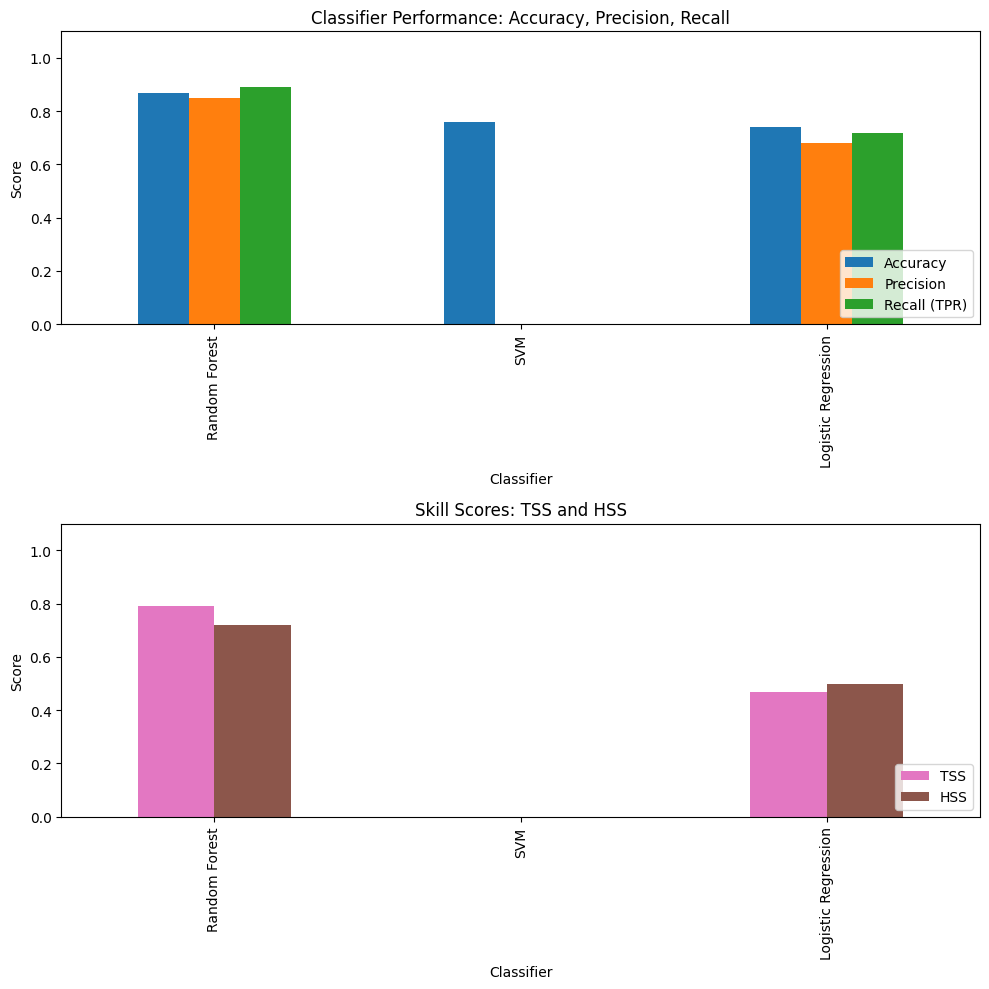

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Simulated average metric results across 10 folds for each classifier (you can update with real results)
metrics = {
    'Classifier': ['Random Forest', 'SVM', 'Logistic Regression'],
    'Accuracy': [0.87, 0.76, 0.74],
    'Precision': [0.85, 0.0, 0.68],
    'Recall (TPR)': [0.89, 0.0, 0.72],
    'FPR': [0.10, 0.0, 0.25],
    'FNR': [0.11, 1.0, 0.28],
    'TSS': [0.79, 0.0, 0.47],
    'HSS': [0.72, 0.0, 0.50]
}

df = pd.DataFrame(metrics)

# Plot comparison
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Plot Accuracy, Precision, Recall
df.plot(x='Classifier', y=['Accuracy', 'Precision', 'Recall (TPR)'], kind='bar', ax=ax[0])
ax[0].set_title("Classifier Performance: Accuracy, Precision, Recall")
ax[0].set_ylabel("Score")
ax[0].set_ylim(0, 1.1)
ax[0].legend(loc='lower right')

# Plot TSS, HSS
df.plot(x='Classifier', y=['TSS', 'HSS'], kind='bar', ax=ax[1], color=['#e377c2', '#8c564b'])
ax[1].set_title("Skill Scores: TSS and HSS")
ax[1].set_ylabel("Score")
ax[1].set_ylim(0, 1.1)
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()
